# Bitcoin cycles

Bitcoin prices in relation to halving cycles.

In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import os
from dotenv import load_dotenv
from btc_cycles import Bitcoin
load_dotenv()

True

## Bitcoin

`Bitcoin` is the main object.

Attributes
- `prices` (pd.DataFrame) : pandas dataframe of prices
- `halvings` (pd.DataFrame) : pandas dataframe of halvings data
- `predicted_halving_block` (int): block of next halving
- `predicted_halving_date` (datetime): date of next predicted 

In [69]:
btc = Bitcoin(
    currency="EUR",
    # source="cryptocompare",
    # api_key=os.getenv("CRYPTOCOMPARE_API_KEY"),
)

Error fetching price data for BTC for interval '28-4-2013' and '18-05-2024'
Error message (download_data) : Expecting value: line 1 column 1 (char 0)


TypeError: 'NoneType' object is not subscriptable

In [ ]:
print(f"Next halving (block {btc.predicted_halving_block}) is predicted on {btc.predicted_halving_date}")

Next halving (block 1050000) is predicted on 2028-03-24 20:40:05+00:00


In [ ]:
btc.halvings.head(10)

,block,reward,Date,cycle_length,cycle_id
0,0,50,2009-01-03 00:00:00+00:00,1425.0,1
1,210000,25.0,2012-11-28 00:00:00+00:00,1319.0,2
2,420000,12.5,2016-07-09 00:00:00+00:00,1402.0,3
3,630000,6.25,2020-05-11 00:00:00+00:00,1440.0,4
4,840000,3.125,2024-04-20 12:09:27+00:00,1434.0,5
5,1050000,1.5625,2028-03-24 20:40:05+00:00,NaN,6
6,1260000,0.78125,NaT,NaN,7
7,1470000,0.390625,NaT,NaN,8
8,1680000,0.195312,NaT,NaN,9
9,1890000,0.097656,NaT,NaN,10


In [ ]:
btc.prices

,Date,Close,block,reward,cycle_length,cycle_id,Halving,ATH,distance_ath_perc,cycle_progress
0,2013-04-28 00:00:00+00:00,127.954255,210000.0,25.000,1319.0,2.0,2012-11-28 00:00:00+00:00,127.954255,0.000000,0.114481
1,2013-04-29 00:00:00+00:00,144.539993,210000.0,25.000,1319.0,2.0,2012-11-28 00:00:00+00:00,144.539993,0.000000,0.115239
2,2013-04-30 00:00:00+00:00,139.000000,210000.0,25.000,1319.0,2.0,2012-11-28 00:00:00+00:00,144.539993,-0.038328,0.115997
3,2013-05-01 00:00:00+00:00,116.989998,210000.0,25.000,1319.0,2.0,2012-11-28 00:00:00+00:00,144.539993,-0.190605,0.116755
4,2013-05-02 00:00:00+00:00,105.209999,210000.0,25.000,1319.0,2.0,2012-11-28 00:00:00+00:00,144.539993,-0.272105,0.117513
...,...,...,...,...,...,...,...,...,...,...
4034,2024-05-14 00:00:00+00:00,61552.790135,840000.0,3.125,1434.0,5.0,2024-04-20 12:09:27+00:00,73083.501328,-0.157774,0.016039
4035,2024-05-15 00:00:00+00:00,66267.491467,840000.0,3.125,1434.0,5.0,2024-04-20 12:09:27+00:00,73083.501328,-0.093263,0.016736
4036,2024-05-16 00:00:00+00:00,65231.580313,840000.0,3.125,1434.0,5.0,2024-04-20 12:09:27+00:00,73083.501328,-0.107438,0.017434
4037,2024-05-17 00:00:00+00:00,67051.874913,840000.0,3.125,1434.0,5.0,2024-04-20 12:09:27+00:00,73083.501328,-0.082531,0.018131


## Plots

The method `plot` prints a chart of the prices.

/Users/giorgiocaizzi/Documents/GitHub/btc-cycles/btc_cycles/artist/static.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.f.tight_layout()


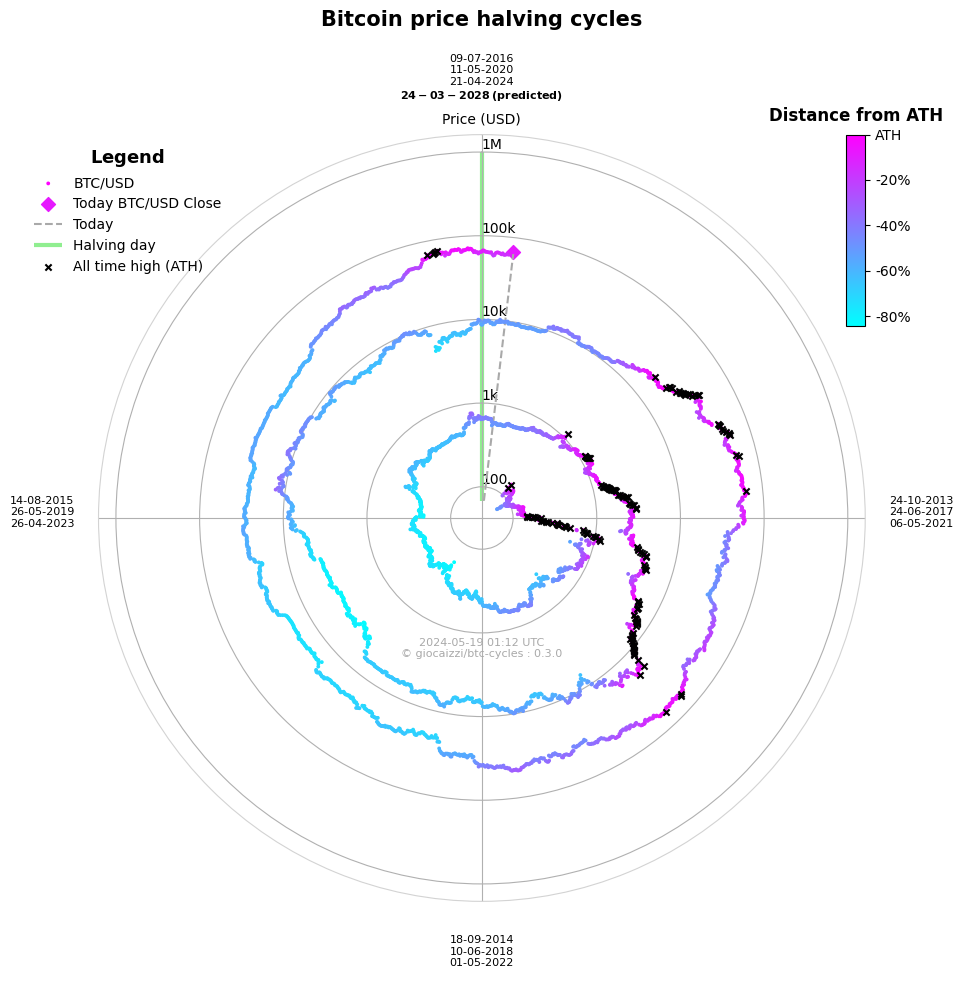

In [ ]:
fig = btc.plot(
    from_date='2012-11-28', # start date
    )
# # fig is a matplotlib figure object
fig.savefig("bitcoin.png")